In [1]:
# Step 1: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Load the accelerometer CSV file
# Replace this with the actual path to your Conflab accelerometer data file
file_path = "/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/v4/release/data_processed/wearables/1.csv"

df = pd.read_csv(file_path)

In [6]:
# Mostrar las columnas y primeras filas
print("Columnas disponibles:")
print(df.columns)


Columnas disponibles:
Index(['time', 'accelX', 'accelY', 'accelZ', 'gyrX', 'gyrY', 'gyrZ', 'magX',
       'magY', 'magZ', 'rotA', 'rotB', 'rotC', 'rotD', 'rssi'],
      dtype='object')


In [7]:
print("Timestamp inicial:", df['time'].iloc[0])
print("Timestamp final:", df['time'].iloc[-1])
print("Duración total:", df['time'].iloc[-1] - df['time'].iloc[0])


Timestamp inicial: 0.0
Timestamp final: 936.98
Duración total: 936.98


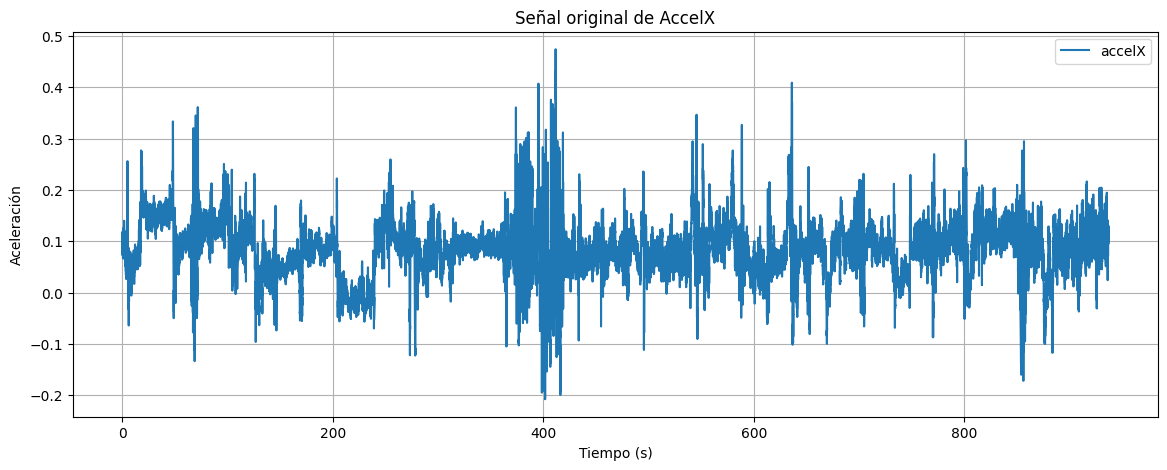

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df['time'], df['accelX'], label='accelX')
plt.title('Señal original de AccelX')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from scipy.signal import butter, filtfilt

# Definir filtro
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band')

# Aplicar filtro
def apply_filter(data, lowcut=0.5, highcut=10.0, fs=50, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

# Frecuencia de muestreo estimada (verifica si tienes el valor real)
fs = 50  # Hz

# Filtrar cada eje
df['accelX_filt'] = apply_filter(df['accelX'], fs=fs)
df['accelY_filt'] = apply_filter(df['accelY'], fs=fs)
df['accelZ_filt'] = apply_filter(df['accelZ'], fs=fs)


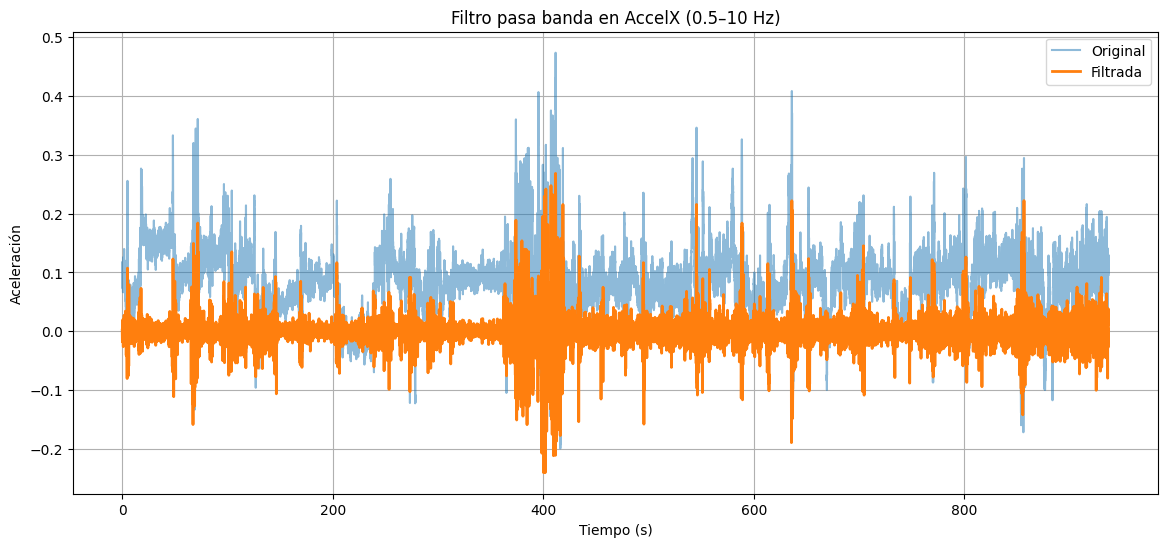

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(df['time'], df['accelX'], label='Original', alpha=0.5)
plt.plot(df['time'], df['accelX_filt'], label='Filtrada', linewidth=2)
plt.title('Filtro pasa banda en AccelX (0.5–10 Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import numpy as np

def segment_signal(df, window_size, step_size, columns):
    segments = []
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df[columns].iloc[start:end].values
        segments.append(window)
    return np.array(segments)

# Aplicamos a las señales filtradas
window_size = 100  # 2 segundos
step_size = 50     # 50% solapamiento

columns = ['accelX_filt', 'accelY_filt', 'accelZ_filt']
segments = segment_signal(df, window_size, step_size, columns)

print(f"Segmentos generados: {segments.shape[0]}")
print(f"Forma de cada segmento: {segments.shape[1:]}")  # (ventana, 3)


Segmentos generados: 936
Forma de cada segmento: (100, 3)


In [13]:
from scipy.stats import skew, kurtosis

def extract_features(segment):
    features = []
    for i in range(segment.shape[1]):  # eje X, Y, Z
        axis = segment[:, i]
        dft = np.abs(np.fft.rfft(axis))
        features.extend([
            np.mean(axis),
            np.std(axis),
            np.var(axis),
            np.sum(axis**2),                      # energía
            ((axis[:-1] * axis[1:]) < 0).sum(),    # zero-crossing rate
            skew(axis),
            kurtosis(axis),
            np.mean(dft),
            np.std(dft),
            np.argmax(dft)                         # frecuencia dominante
        ])
    return features


In [14]:
features = [extract_features(seg) for seg in segments]
X = np.array(features)

print(f"Feature vector shape: {X.shape}")  # (n_segmentos, n_features)


Feature vector shape: (936, 30)


In [15]:
#TEMPORAL
n = X.shape[0]
y = np.array([0 if i < n / 2 else 1 for i in range(n)])  # demo temporal


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.59      0.66       147
           1       0.64      0.79      0.71       134

    accuracy                           0.69       281
   macro avg       0.70      0.69      0.69       281
weighted avg       0.70      0.69      0.68       281



In [24]:
annotations_path = "/Volumes/staff-bulk/ewi/insy/SPCDataSets/conflab-mm/v4/release/annotations/actions/laughing/Only_Audio/vid2_seg7_ann1.csv"
df_ann = pd.read_csv(annotations_path)

# Ver columnas (participantes)
print("Participantes:", df_ann.columns.tolist())

# Ver primeros valores
print(df_ann.head())


Participantes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']
   1  2  3  4  5  6  7  8  9  10  ...  41  42  43  44  45  46  47  48  49  50
0  0  0  0  0  0  0  0  0  0   0  ...   0   0   0   0   0   0   0   0   0   0
1  0  0  0  0  0  0  0  0  0   0  ...   0   0   0   0   0   0   0   0   0   0
2  0  0  0  0  0  0  0  0  0   0  ...   0   0   0   0   0   0   0   0   0   0
3  0  0  0  0  0  0  0  0  0   0  ...   0   0   0   0   0   0   0   0   0   0
4  0  0  0  0  0  0  0  0  0   0  ...   0   0   0   0   0   0   0   0   0   0

[5 rows x 48 columns]
